# Tutorial: Audio and Sheet Music Embedding
In this tutorial we show how to apply the embedding networks to both,
- new sheet music as well as
- new audio files.

First we need to import a couple of standard python packages
for loading and visualizing the data.
We require additional imports later on,
but import the packages where they are applied to show how things are related.

**Pre-requisite : Clone the 'Audio Sheet Retrieval' using command** :

!git clone https://github.com/CPJKU/audio_sheet_retrieval.git 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install theano==1.0.5

  Using cached Theano-1.0.5-py3-none-any.whl


In [ ]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

  Using cached https://github.com/Theano/Theano/archive/master.zip (13.4 MB)
  Using cached https://github.com/Lasagne/Lasagne/archive/master.zip


In [ ]:
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'

In [1]:
# Small code snippet to check if theano is working fine!
from theano import function
from theano import tensor as T

x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
f = function([x, y], z)

In [ ]:
from __future__ import print_function

import cv2
import numpy as np
import matplotlib.pyplot as plt

# this is the default height of our staff systems
# (it is fixed as we process it with a convolutional neural network)
SYSTEM_HEIGHT = 160

# path to sheet image file

#sheet_img_path = "sheet_image.png"
#sheet_img_path = "Jingle_bell_adv.png"
sheet_img_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/SheetImages/PNGFiles/AveMariaInter.png"
#sheet_img_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/SheetImages/PNGFiles/Feiz_Nevidad _inter.png"
#sheet_img_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/SheetImages/PNGFiles/WeThreeKingsInter.png"
#sheet_img_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/SheetImages/PNGFiles/LittleDrummerBoyAdv.png"
#sheet_img_path = "/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials/sheet_image.png"
# path to audio file
#audio_path = "audio.mp3"
audio_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/AveMariaInter.wav"
#audio_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/WeThreeKingsInter.wav"
#audio_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/LittleDrummerBoyAdv.wav"
# audio_path = "/content/gdrive/MyDrive/BaselineExperiments/BaselineDataset/WavFiles/small_dog_bark_IgU_UsS.wav"
#audio_path = "/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials/audio.mp3"

In [ ]:
import os
os.getcwd()

'/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials/mysongs'

In [ ]:
%cd /content/gdrive/MyDrive/audio_sheet_retrieval/tutorials

/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials


## Loading a Sheet Image
Next we load a sheet image an resize it to our target image width of 835 pixels.<br>
We provide a test sheet image in the folder of this tutorial (*sheet_image.png*).

In [ ]:
def resize_img(I):
    """
    Resize image to target width of 835 pxls
    """
    width = 835
    scale = float(width) / I.shape[1]
    height = int(scale * I.shape[0])
    I = cv2.resize(I, (width, height))
    return I

In [ ]:
# load sheet image
sheet_image = cv2.imread(sheet_img_path, 0)
sheet_image = resize_img(sheet_image)

## Automatic System Detection
The next step is to detect staff systems in the sheet image
in order to be able to unroll the score into one long staff line.
This will make further processing much easier
and we require this anyways to feed the score image into our network.

Along with our project we provide some simple Optical Music Recognition (OMR) Tools.
This is how we import them:

In [ ]:
%cd ..

/content/gdrive/MyDrive/audio_sheet_retrieval


In [ ]:
%cd /content/gdrive/MyDrive/audio_sheet_retrieval/

/content/gdrive/MyDrive/audio_sheet_retrieval


In [ ]:
import os
os.getcwd()

'/content/gdrive/MyDrive/audio_sheet_retrieval'

In [ ]:
# import omr stuff
from audio_sheet_retrieval.sheet_utils.omr import OpticalMusicRecognizer, prepare_image
from audio_sheet_retrieval.sheet_utils.omr import SegmentationNetwork
from audio_sheet_retrieval.sheet_utils import system_detector, bar_detector

Having the OMR module imported, we initialize it with the provided pre-trained models:

In [ ]:
%cd  /content/gdrive/MyDrive/audio_sheet_retrieval/tutorials

/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials


In [ ]:
%cd  /content/gdrive/MyDrive/audio_sheet_retrieval/audio_sheet_retrieval/sheet_utils

/content/gdrive/MyDrive/audio_sheet_retrieval/audio_sheet_retrieval/sheet_utils


In [ ]:
import numpy as np
# initialize system detection
net = system_detector.build_model()
system_net = SegmentationNetwork(net)
system_net.load('/content/gdrive/MyDrive/audio_sheet_retrieval/audio_sheet_retrieval/sheet_utils/omr_models/system_params.pkl')

# initialize bar detection
net = bar_detector.build_model()
bar_net = SegmentationNetwork(net)
bar_net.load('/content/gdrive/MyDrive/audio_sheet_retrieval/audio_sheet_retrieval/sheet_utils/omr_models/bar_params.pkl')

# initialize OMR system
omr = OpticalMusicRecognizer(note_detector=None, system_detector=system_net, bar_detector=bar_net)

Once the OMR system is initialized system detection should become easy:

In [ ]:
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
# prepare image for processing with network (e.g. conversion to float32)
sheet_image_prep = prepare_image(sheet_image)

# detect systems
page_systems = omr.detect_systems(sheet_image_prep, verbose=False)

Let's visualize the result:

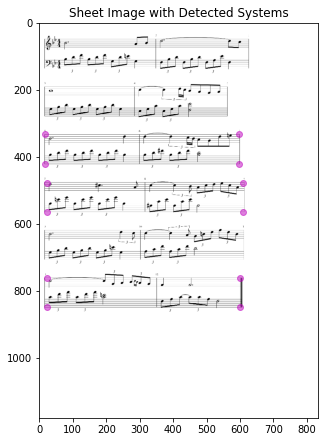

In [ ]:
plt.figure("System Localization", figsize=(5, 10))
plt.clf()
plt.imshow(sheet_image, cmap=plt.cm.gray)
plt.xlim([0, sheet_image.shape[1] - 1])
plt.ylim([sheet_image.shape[0] - 1, 0])
for system in page_systems:
    plt.plot(system[:, 1], system[:, 0], 'mo', alpha=0.5)
plt.title("Sheet Image with Detected Systems")
plt.show()

## Unrolling the Score
Given the detected systems the next step is to unroll the score.
Here is how we can do this:

In [ ]:
# unwrap sheet given system detections
unwrapped_sheet = np.zeros((SYSTEM_HEIGHT, 0), dtype=np.uint8)
for system in page_systems:

    r0 = int(np.mean([system[0, 0], system[2, 0]])) - SYSTEM_HEIGHT // 2
    r1 = r0 + SYSTEM_HEIGHT
    c0 = int(system[0, 1])
    c1 = int(system[1, 1])

    # fix row slice coordinates
    r0 = max(0, r0)
    r1 = min(r1, sheet_image.shape[0])
    r0 = max(r0, r1 - SYSTEM_HEIGHT)

    staff_img = sheet_image[r0:r1, c0:c1].astype(np.uint8)

    if staff_img.shape[0] < SYSTEM_HEIGHT:
        to_pad = SYSTEM_HEIGHT - staff_img.shape[0]
        if to_pad > (0.1 * SYSTEM_HEIGHT):
            print("Problem in system padding!!!")
            continue
        staff_img = np.pad(staff_img, ((0, to_pad), (0, 0)), mode="edge")

    unwrapped_sheet = np.hstack((unwrapped_sheet, staff_img))

Again, this is what we get as a result:

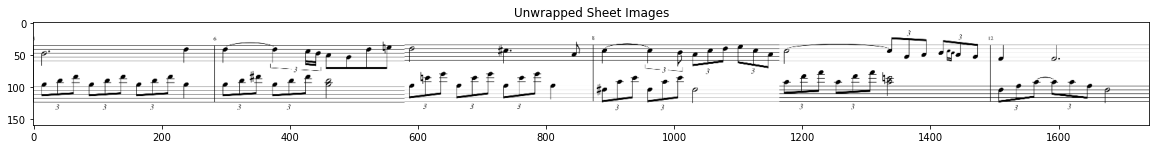

In [ ]:
plt.figure("Unwrapped Sheet Image", figsize=(20, 5))
plt.clf()
plt.imshow(unwrapped_sheet, cmap=plt.cm.gray)
plt.title("Unwrapped Sheet Images")
plt.show()

## Sheet Snippet Embedding
To make working with our networks easier,
we wrap all the theano code into one retrieval class (*RetrievalWrapper*).
In addition we also import the definition file of our retrieval model (*mutopia_ccal_cont_rsz*).

In [ ]:
%cd /content/gdrive/MyDrive/audio_sheet_retrieval

/content/gdrive/MyDrive/audio_sheet_retrieval


In [ ]:
pip install muscima

In [ ]:
pip install madmom

In [ ]:
pip install pretty_midi

In [ ]:
# this class contains some convenience code for embedding computation
from audio_sheet_retrieval.retrieval_wrapper import RetrievalWrapper
%cd /content/gdrive/MyDrive/audio_sheet_retrieval/
# this is our retrieval model
from audio_sheet_retrieval.models import mutopia_ccal_cont_rsz as model

/content/gdrive/MyDrive/audio_sheet_retrieval


In [ ]:
%cd /content/gdrive/MyDrive/audio_sheet_retrieval/tutorials

/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials


Next we initialize the encoder networks with a set of pre-trained weights.

In [ ]:
# path to network parameters
param_file = "params_all_split_mutopia_full_aug.pkl"

# this function is called before a snippet is fed to the network
# (for the present model it resizes the image by a factor of 2)
prepare_sheet_img = model.prepare

# initialize retrieval wrapper
embed_network = RetrievalWrapper(model, param_file, prepare_view_1=prepare_sheet_img, prepare_view_2=None)

# this are dimensions of sheet image snippet and audio excerpt
snippet_shape = model.INPUT_SHAPE_1[1:]
excerpt_shape = model.INPUT_SHAPE_2[1:]
print("snippet_shape", snippet_shape)
print("excerpt_shape", excerpt_shape)

Building network ...
Loading model parameters from: params_all_split_mutopia_full_aug.pkl
Compiling prediction functions ...
snippet_shape [160, 200]
excerpt_shape [92, 42]


Then we slice the unrolled sheet image into 100 small snippets.

In [ ]:
# slice central part of unrolled sheet
r0 = unwrapped_sheet.shape[0] // 2 - snippet_shape[0] // 2
r1 = r0 + snippet_shape[0]

In [ ]:
# equally sample 100 snippets
n_samples = 100
start_indices = np.linspace(start=0, stop=unwrapped_sheet.shape[1]-snippet_shape[1], num=n_samples)
start_indices = start_indices.astype(int)

In [ ]:
# collect sheet snippets
sheet_snippets = np.zeros((len(start_indices), 1, snippet_shape[0], snippet_shape[1]), dtype=np.float32)
for i, idx in enumerate(start_indices):
    sheet_snippets[i, 0] = unwrapped_sheet[r0:r1, idx:idx+snippet_shape[1]]

print("Sheet snippet shape", sheet_snippets.shape)

Sheet snippet shape (100, 1, 160, 200)


Finally, we feed the sheet snippets through the image part of the encoding network
and end up with 100 32-dimensional vectors.

In [ ]:
# compute sheet snippet codes
sheet_codes = embed_network.compute_view_1(sheet_snippets)
print("Sheet code shape", sheet_codes.shape)

Sheet code shape (100, 32)


## Audio Excerpt Embedding
Above we have shown how to compute image embeddings starting from an entire score image.
In this part of the notebook we explain with its counterpart, an music audio.

The first thing we need to do is to compute a spectrogram from the audio file.

In [ ]:
%cd /content/gdrive/MyDrive/audio_sheet_retrieval/tutorials/mysongs

/content/gdrive/MyDrive/audio_sheet_retrieval/tutorials/mysongs


In [ ]:
# this is what we need to import from the madmom project
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor
from madmom.processors import SequentialProcessor

# init signal processing as described in the paper
SAMPLE_RATE = 22050
FRAME_SIZE = 2048
FPS = 20

sig_proc = SignalProcessor(num_channels=1, sample_rate=SAMPLE_RATE)
fsig_proc = FramedSignalProcessor(frame_size=FRAME_SIZE, fps=FPS, origin='future')
spec_proc = FilteredSpectrogramProcessor(LogarithmicFilterbank, num_bands=16, fmin=30, fmax=6000)  # num_bands=24, fmin=30, fmax=8000
log_spec_proc = LogarithmicSpectrogramProcessor()
processor = SequentialProcessor([sig_proc, fsig_proc, spec_proc, log_spec_proc])

# compute spectrogram
spectrogram = processor.process(audio_path).T

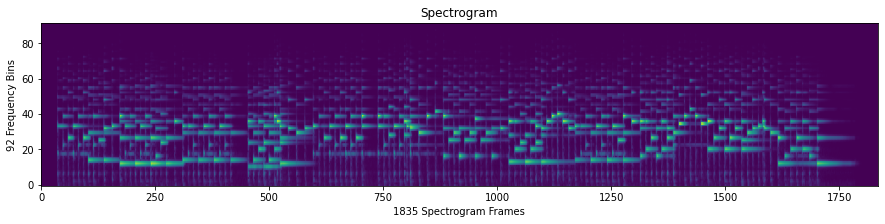

In [ ]:
plt.figure("Spectrogram", figsize=(15, 3))
plt.clf()
plt.imshow(spectrogram, cmap="viridis", aspect="auto", origin="lower")
plt.title("Spectrogram")
plt.ylabel("%d Frequency Bins" % spectrogram.shape[0])
plt.xlabel("%d Spectrogram Frames" % spectrogram.shape[1])
plt.show()

Given this spectrogram we proceed as with the unrolled sheet image
by slicing it into 100 small excerpts.

In [ ]:
n_samples = 100
start_indices = np.linspace(start=0, stop=spectrogram.shape[1]-excerpt_shape[1], num=n_samples)
start_indices = start_indices.astype(int)

# collect spectrogram excerpts
spec_excerpts = np.zeros((len(start_indices), 1, excerpt_shape[0], excerpt_shape[1]), dtype=np.float32)
for i, idx in enumerate(start_indices):
    spec_excerpts[i, 0] = spectrogram[:, idx:idx+excerpt_shape[1]]

print("Spectrogram excerpt shape", spec_excerpts.shape)

Spectrogram excerpt shape (100, 1, 92, 42)


The last thing to do is to feed the spectrogram excerpts through the audio part of the encoding network
to again end up with 100 32-dimensional vectors.

In [ ]:
# compute spectrogram codes
spec_codes = embed_network.compute_view_2(spec_excerpts)
print("Spectrogram code shape", spec_codes.shape)

Spectrogram code shape (100, 32)


## Toy Application: Embedding Space Distance
To see if everything worked out we simply compute the pairwise distance between sheet image snippets and audio excerpts in embedding space.
The image of the distance matrix below should contain a dark diagonal line of very small distances.
This could be for example the input to a nearest neighbor search or Dynamic Time Warping (DTW) in the case of alignment.

# Below, we try visualzing sheet image and audio snippet for different songs in common embedding space!

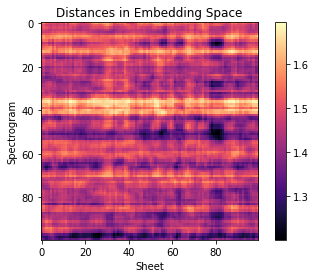

[[1.55864148 1.57190246 1.51937039 ... 1.52854463 1.4829382  1.49295468]
 [1.50587364 1.52021396 1.48212502 ... 1.47904461 1.43699694 1.45795638]
 [1.49656657 1.52761321 1.50892554 ... 1.46768509 1.43524528 1.46367148]
 ...
 [1.3362103  1.36177733 1.36375418 ... 1.27627636 1.32100758 1.35622939]
 [1.3047818  1.30701132 1.28479243 ... 1.2517541  1.30215075 1.30751823]
 [1.36973916 1.34275519 1.2971197  ... 1.34360886 1.41381873 1.41776315]]
1.2354386764291794
Arithmetic Mean is : [0.38809342 0.68572354 0.93373276 ... 0.34407574 0.8145165  0.82625328]


In [ ]:
#audio.mp3
#sheet_image.png

from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)


plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()

from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  



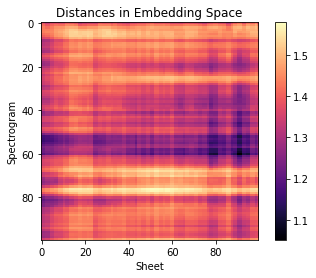

[[1.37245002 1.37245002 1.33971915 ... 1.40766784 1.4371674  1.37965137]
 [1.41436176 1.41436176 1.38724084 ... 1.46176456 1.48563405 1.43780583]
 [1.43266451 1.43266451 1.41668585 ... 1.49248509 1.50549406 1.47004239]
 ...
 [1.28641807 1.28641807 1.29150767 ... 1.36377787 1.37066869 1.37424315]
 [1.27858854 1.27858854 1.28862885 ... 1.36917269 1.37349096 1.38336936]
 [1.34859978 1.34859978 1.3615717  ... 1.456308   1.46061545 1.46950731]]
0.9418095249813522
Arithmetic Mean is : [0.55639648 0.98688077 1.07616335 ... 0.12687921 0.89451775 0.79580241]


In [ ]:
#small_dog_bark_IgU_UsS.wav
#LittleDrummerBoyAdv.png

from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)


plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()

from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  



In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  

# AveMariaInter.wav
# AveMariaInter.png

[[1.31149178 1.39683527 1.50297398 ... 1.39954514 1.41468763 1.29652574]
 [1.30455483 1.40365734 1.53095755 ... 1.42007847 1.42094163 1.28900344]
 [1.30692046 1.40700946 1.52892001 ... 1.40606722 1.41194468 1.29153718]
 ...
 [1.20972174 1.30807215 1.41519377 ... 1.18802287 1.24969533 1.18069851]
 [1.18557044 1.28210112 1.42785115 ... 1.20865403 1.23939995 1.15923517]
 [1.13448723 1.251658   1.42383423 ... 1.16840506 1.19986481 1.10368224]]
0.9755743825826049
Arithmetic Mean is : [0.27770979 0.23540496 0.12438614 ... 0.22222047 0.23075068 0.17878186]


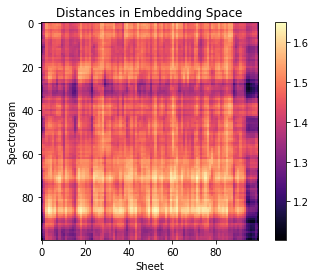

In [ ]:
plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()

# AveMariaInter.wav
# AveMariaInter.png

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  

# AveMariaInter.wav
# AveMariaInter.png

[[1.12037871 1.253069   1.26848403 ... 1.01915994 1.05900371 1.12175302]
 [1.19606712 1.3588123  1.36679702 ... 1.06870174 1.14367241 1.19412841]
 [1.33060987 1.45090468 1.45074202 ... 1.24807065 1.32154384 1.3625477 ]
 ...
 [1.24061445 1.31118366 1.33205752 ... 1.1097778  1.14951865 1.20146483]
 [1.2506949  1.28645797 1.31485615 ... 1.12851813 1.17329497 1.24898017]
 [1.34015917 1.36657314 1.35800345 ... 1.24132768 1.27594103 1.32455535]]
0.7850909615900149
Arithmetic Mean is : [0.84237638 1.74968413 1.70400444 ... 0.24075902 0.42970373 0.48833452]


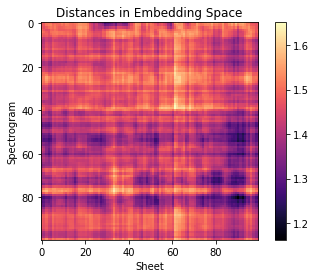

In [ ]:
plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()

# WeThreeKingsInter.wav
# WeThreeKingsInter.png

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  

# WeThreeKingsInter.wav
# WeThreeKingsInter.png

[[1.12037871 1.253069   1.26848403 ... 1.01915994 1.05900371 1.12175302]
 [1.19606712 1.3588123  1.36679702 ... 1.06870174 1.14367241 1.19412841]
 [1.33060987 1.45090468 1.45074202 ... 1.24807065 1.32154384 1.3625477 ]
 ...
 [1.24061445 1.31118366 1.33205752 ... 1.1097778  1.14951865 1.20146483]
 [1.2506949  1.28645797 1.31485615 ... 1.12851813 1.17329497 1.24898017]
 [1.34015917 1.36657314 1.35800345 ... 1.24132768 1.27594103 1.32455535]]
0.7850909615900149
Arithmetic Mean is : [0.84237638 1.74968413 1.70400444 ... 0.24075902 0.42970373 0.48833452]


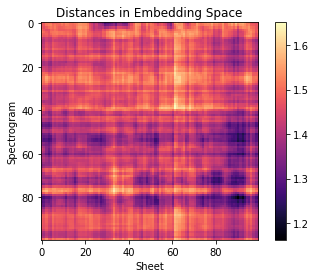

[[1.25517526 1.31464443 1.35341701 ... 1.26612086 1.26577951 1.22762132]
 [1.30011811 1.34536958 1.38655838 ... 1.30999099 1.32177319 1.29338255]
 [1.32542684 1.36093946 1.39287235 ... 1.26175045 1.27756576 1.27277899]
 ...
 [1.2899993  1.19776174 1.09791769 ... 1.06748014 1.08205989 1.22145896]
 [1.35402004 1.25670558 1.1494203  ... 1.14444399 1.16331667 1.28936611]
 [1.48148765 1.39044199 1.26093071 ... 1.26148688 1.27964912 1.39490798]]
0.8641449930929713
Arithmetic Mean is : [0.1897805  0.66218804 1.1840911  ... 0.3650811  1.43120788 1.08983003]


In [ ]:

plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Sheet")
plt.ylabel("Spectrogram")
plt.colorbar()
plt.show()

from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(sheet_codes, spec_codes)

from sklearn.metrics.pairwise import euclidean_distances
sklearn_dist = euclidean_distances(sheet_codes, spec_codes)
print(sklearn_dist)

print(pairwise_distances(sheet_codes[0:1], spec_codes, metric='cosine')[0,1])

from scipy.spatial.distance import pdist
print("Arithmetic Mean is :", pdist(sklearn_dist))  

#LittleDrummerBoyAdv.wav
#LittleDrummerBoyAdv.png